## Final Project Submission

Please fill out:
* Student name: Reuben Hough
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Ahbineet Kulkarni
* Blog post URL:


In [1]:
import warnings
import pandas as pd
import sys
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder, scale, label_binarize, normalize, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from numpy import random
from contextlib import redirect_stdout
from io import StringIO
from time import time

In [2]:
# warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv('cleaneddf.csv', low_memory=False)
test = pd.read_csv('cleantest.csv', low_memory=False)

In [4]:
def display_all(df):
    with pd.option_context('display.max_rows', 1000):
        with pd.option_context('display.max_columns', 1000):
            display(df)

In [5]:
display_all(train.head())

,id,gps_height,longitude,latitude,basin,region_code,lga,population,public_meeting,permit,extraction_type_class,management,payment,water_quality,quantity,source,source_class,waterpoint_type,status_group,year,month,selfbuilt,NaN Counts
0,69572,1390.0,34.938093,-9.856322,1,10,51,109,1,0,0,7,2,5,1,8,0,1,functional,2011,3,0,25
1,8776,1399.0,34.698766,-2.147466,4,19,103,280,1,1,0,11,0,5,2,5,1,1,functional,2013,3,0,24
2,34310,686.0,37.460664,-3.821329,5,20,108,250,1,1,0,7,4,5,1,0,1,2,functional,2013,2,1,25
3,67743,263.0,38.486161,-11.155298,7,24,87,58,1,1,5,7,0,5,0,3,0,2,non functional,2013,1,0,25
4,19728,1317.0,31.130847,-1.825359,4,17,26,0,1,1,0,1,0,5,3,5,1,1,functional,2011,7,1,24


In [6]:
train['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [7]:
# I'll now encode the status group, making sure to note
# which number refers to which status
le = LabelEncoder().fit(train['status_group'])
train['status_group'] = le.transform(train['status_group'])

In [8]:
y = train['status_group']
X = train.drop(['status_group', 'id'], axis=1)

It encoded "functional" as 0, "functional needs repair" as 1, and "non functional" as 2. Another useful way to encode the labels is by turning them into zeros and ones.

In [9]:
Y = label_binarize(y, classes=[0, 1, 2])

In [10]:
# There are four times as many entries in the train set, 
# so I'll use .20 when testing classification
train.shape[0]/test.shape[0]

4.0

In [11]:
# Doing a test/train split on the training data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=8)

In [12]:
# and a second time with binary labels
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20,random_state=8)

In [13]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=8)
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=8, splitter='best')

In [14]:
dt.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=8, splitter='best')

In [15]:
def statistics(clf):
    names = ["functional", "functional needs repair", "non functional"]
    print('_' * 78)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(x_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    matrix = metrics.confusion_matrix(y_test, pred)
    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time, matrix

In [16]:
results = []

for clf, name in [(RidgeClassifier(), "Ridge Classifier"),(XGBClassifier(), "XGBoost"),
                  (KNeighborsClassifier(), "K Nearest Neighbors"),
                  (RandomForestClassifier(), "Random Forest"),
                  (AdaBoostClassifier(), "AdaBoost Classifier"),
                  (GradientBoostingClassifier(), "Gradient Boosting Classifier")]:
    print(name)
    results.append(statistics(clf))

Ridge Classifier
______________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)
train time: 0.033s
test time:  0.003s
accuracy:   0.615

XGBoost
______________________________________________________________________________
Training: 
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
train time: 6.280s
test time:  0.081s
accuracy:   0.741

K Nearest Neighbors
___

C:\Users\reube\.conda\envs\learn-env\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


train time: 0.691s
test time:  0.031s
accuracy:   0.792

AdaBoost Classifier
______________________________________________________________________________
Training: 
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
train time: 2.446s
test time:  0.078s
accuracy:   0.719

Gradient Boosting Classifier
______________________________________________________________________________
Training: 
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           

In [17]:
# Get confusion matrix here
results[5]

('GradientBoostingClassifier',
 0.7451178451178451,
 15.171144008636475,
 0.05000495910644531,
 array([[5997,   46,  426],
        [ 663,  110,   99],
        [1766,   28, 2745]], dtype=int64))

In [18]:
results = [[x[i] for x in results] for i in range(4)]

In [19]:
results

[['RidgeClassifier',
  'XGBClassifier',
  'KNeighborsClassifier',
  'RandomForestClassifier',
  'AdaBoostClassifier',
  'GradientBoostingClassifier'],
 [0.6146464646464647,
  0.7410774410774411,
  0.6734848484848485,
  0.7922558922558922,
  0.7193602693602693,
  0.7451178451178451],
 [0.03299999237060547,
  6.280472755432129,
  0.07300424575805664,
  0.691051721572876,
  2.4461848735809326,
  15.171144008636475],
 [0.003004789352416992,
  0.08100605010986328,
  0.5180397033691406,
  0.03100132942199707,
  0.07800793647766113,
  0.05000495910644531]]

In [20]:
indices = np.arange(len(results[1]))

# results = [[x[i] for x in results] for i in range(4)]

In [21]:
clf_names, score, train_time, test_time = [[x for x in results[i]] for i in range(4)]

In [22]:
clf_names, score, train_time, test_time

(['RidgeClassifier',
  'XGBClassifier',
  'KNeighborsClassifier',
  'RandomForestClassifier',
  'AdaBoostClassifier',
  'GradientBoostingClassifier'],
 [0.6146464646464647,
  0.7410774410774411,
  0.6734848484848485,
  0.7922558922558922,
  0.7193602693602693,
  0.7451178451178451],
 [0.03299999237060547,
  6.280472755432129,
  0.07300424575805664,
  0.691051721572876,
  2.4461848735809326,
  15.171144008636475],
 [0.003004789352416992,
  0.08100605010986328,
  0.5180397033691406,
  0.03100132942199707,
  0.07800793647766113,
  0.05000495910644531])

In [23]:
[x for x in results[0]]

['RidgeClassifier',
 'XGBClassifier',
 'KNeighborsClassifier',
 'RandomForestClassifier',
 'AdaBoostClassifier',
 'GradientBoostingClassifier']

In [24]:
results

[['RidgeClassifier',
  'XGBClassifier',
  'KNeighborsClassifier',
  'RandomForestClassifier',
  'AdaBoostClassifier',
  'GradientBoostingClassifier'],
 [0.6146464646464647,
  0.7410774410774411,
  0.6734848484848485,
  0.7922558922558922,
  0.7193602693602693,
  0.7451178451178451],
 [0.03299999237060547,
  6.280472755432129,
  0.07300424575805664,
  0.691051721572876,
  2.4461848735809326,
  15.171144008636475],
 [0.003004789352416992,
  0.08100605010986328,
  0.5180397033691406,
  0.03100132942199707,
  0.07800793647766113,
  0.05000495910644531]]

In [25]:
train_time = np.array(train_time) / np.max(train_time)
test_time = np.array(test_time) / np.max(test_time)

In [26]:
len(train_time)


6

In [27]:
len(indices)

6

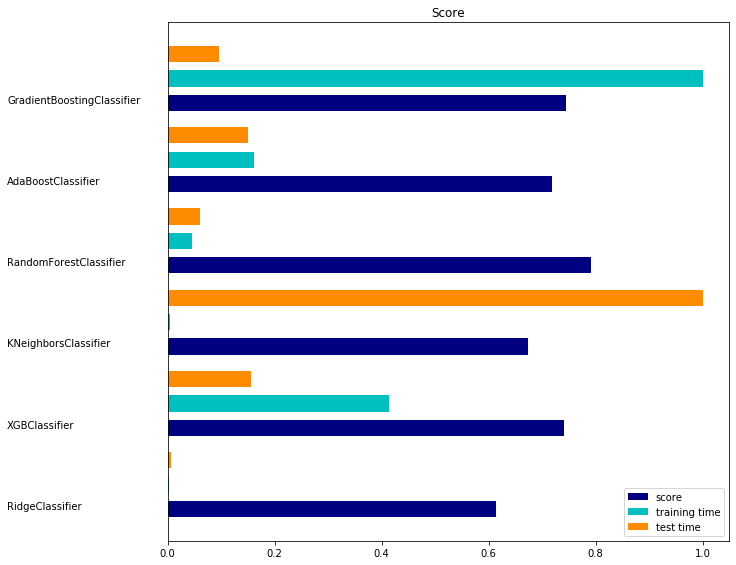

In [28]:
plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, train_time, .2, label="training time",color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for a, b in zip(indices, clf_names):
    plt.text(-.3, a, b)

plt.show()

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhatGS)
np.set_printoptions(precision=2)

print (classification_report(y_test, yhatGS))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Functional',
                                           'Functional needs repair', 
                                           'Non functional'],
                                            normalize= False,
                                            title='Confusion matrix')

NameError: name 'yhatGS' is not defined